# Link predicyion example using the GNN learning engine under the RelationalAI Snowflake Native App

## ✅ Prerequisites

Before running this notebook, make sure you've completed the following setup steps:

1. **Install the RelationalAI Experimental Application**
   Ensure that the RelationalAI experimental app is installed in your Snowflake account.

2. **Preprocess the Tokenflow Dataset**
   Run the `preprocess_tokenflow_data.ipynb` notebook to generate the processed dataset required for this tutorial.

3. **Upload the Preprocessed Data to Snowflake**
   Use the preprocessing notebook to upload the Tokenflow data to the appropriate tables in your Snowflake environment.

4. **Install the RelationalAI GNN Python SDK**
   Follow the installation steps provided in the [README.md](GNN_SDK_DOCUMENTATION.md) to set up the RelationalAI GNN SDK in your environment.

### 🔐 Connecting to the RelationalAI Native App via Snowflake

To connect to the RelationalAI native app, we'll first set up a `.env` file that defines the necessary environment variables for establishing a Snowflake connection.

We assume you have created a `.env` file in the same directory as this notebook. (A sample `.env` file is included for reference.)

Your `.env` file should contain the following fields:

```
ACCOUNT_NAME=snowflake_account_name
USER_NAME=snowflake_user_name
PASSWORD=snowflake_user_password
WAREHOUSE=snowflake_warehouse
APP_NAME=RAI_EXPT_APP
AUTH_METHOD=password
```

#### 🔎 Need help finding your Snowflake account name?

You can retrieve your account identifier by running the following SQL command in Snowflake:

```sql
SELECT CURRENT_ORGANIZATION_NAME() || '-' || CURRENT_ACCOUNT_NAME();
```

#### 🔐 About Authentication

In this tutorial, we’ll use **password authentication**. However, other authentication methods—such as **Key Pair Authentication** or **OAuth Token Authentication**—are also supported. For more details, refer to the [RelationalAI GNN documentation](GNN_SDK_DOCUMENTATION.md).



In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# load the snowflake configuration to a python dict
snowflake_config = {
    "account": os.getenv("ACCOUNT_NAME"),
    "user": os.getenv("USER_NAME"),
    "password": os.getenv("PASSWORD"),
    "warehouse": os.getenv("WAREHOUSE"),
    "app_name": os.getenv("APP_NAME"),
    "auth_method": os.getenv("AUTH_METHOD")
}


## ⚙️ Managing Your GNN Engines

The `Provider` class in the RelationalAI GNN SDK allows you to manage your GNN engines seamlessly. Below, we walk through common operations you can perform with the `Provider`:

* ✅ Create a new GNN engine
* 📋 List all available engines
* 🔍 Check the status of an engine
* 🔄 Resume a paused engine
* ❌ Delete an engine

Each of these operations can be done with simple method calls, as shown in the following examples.


In [3]:
from rai_gnns_experimental import Provider

In [4]:
# initialize the provider using the snowflake configuration
# (note: you might be prompted from your MFA app at this point)
provider = Provider(**snowflake_config)

In [5]:
# list the available engines.
provider.list_gnns()

[{'name': 'my_engine',
  'id': '52caa0f92afa',
  'size': 'GPU_NV_S',
  'state': 'READY',
  'created_by': 'TOKENFLOW_DEV_GNN',
  'created_on': datetime.datetime(2025, 6, 19, 9, 4, 27, 792000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>),
  'updated_on': datetime.datetime(2025, 6, 23, 9, 12, 11, 883000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>),
  'settings': {'mlflowendpoint': 'https://asf6z5-wcwhvmh-tokenflow-dev.snowflakecomputing.app'}}]

In [ ]:
# We can also create a new GNN engine, currently two
# engine types are supported "GPU_NV_S" and "HIGHMEM_X64_S"
# here we create an engine by specifying the engine name (a
# custom name) and also the type of the engine, specified by the
# "size" parameter
provider.create_gnn(name="my_engine", size="GPU_NV_S")

In [ ]:
# now we can directly see the status of the engine
# the status of the engine 'READY' marks the fact that the
# engine is ready to be used. A `PENDING` status marks the
# fact that the engine has  been automaticaly suspended.
# Notice also that under the settings 
# the provider exposes a URL for the MLFLOW endpoint
# that we can use to track our experiments
provider.get_gnn("my_engine")

In [ ]:
# HINT: We can always resume a GNN engine that has been suspended:
# Note: Engine provisioning can take some minutes. Please
# check the engine status using provider.get_gnn(name="my_engine")

# provider.resume_gnn(name="my_engine")

# And if we need we can also delete a GNN engine

# provider.delete_gnn(name="ilias_test_engine")

## 🔌 Connector Setup

The `Connector` class, like the `Provider` class, is used to communicate with Snowflake. However, while the `Provider` is responsible for managing GNN engines, the `Connector` is specifically used to interface with the **GNN learning engine** itself.

You’ll use the `Connector` instance as an input to all SDK components that need to send requests to the GNN engine—such as loading data, running training jobs, or performing inference.

In short:

* `Provider` → Manages GNN engine instances (create, list, delete, etc.)
* `Connector` → Sends requests to a specific GNN engine for processing tasks

Let’s now walk through how to create and use a `Connector`.


In [6]:
from rai_gnns_experimental import SnowflakeConnector

In [7]:
# we initialize the connector and passing all our credentials.
connector = SnowflakeConnector(
    **snowflake_config,
    engine_name="my_engine",
)
# the connector also provides access to MLFLOW that you can
# use to monitor your experiments and register trained GNN models
connector.mlflow_session_url

'https://asf6z5-wcwhvmh-tokenflow-dev.snowflakecomputing.app'

## 📊 Preparing the data: Creating the GNN tables

In this section, we will define the GNN tables and the associated learning task. These components will then be used to construct a GNN dataset suitable for training.

For this tutorial, we’ll use the Tokenflow database as our working example. This database includes three tables: BUYERS, SENDERS, and TRANSACTIONS. The TRANSACTIONS table links BUYERS to SENDERS. Our objective is to predict which BUYERS a given SENDER is most likely to transact with in the future—framing this as a link prediction task.

Before loading the data, ensure that your application has the necessary permissions to access the relevant tables. In Snowflake, this can be achieved by running the following commands:

```sql
-- Grant usage on the database to the application
GRANT USAGE ON DATABASE GNN_TOKENFLOW TO APPLICATION RELATIONALAI;

-- Grant usage on the schema to the application
GRANT USAGE ON SCHEMA GNN_TOKENFLOW.DATA TO APPLICATION RELATIONALAI;
GRANT USAGE ON SCHEMA GNN_TOKENFLOW.TASK TO APPLICATION RELATIONALAI;

-- Grant read access to a specific table
GRANT SELECT ON TABLE GNN_TOKENFLOW.DATA.BUYERS TO APPLICATION RELATIONALAI;
GRANT SELECT ON TABLE GNN_TOKENFLOW.DATA.SENDERS TO APPLICATION RELATIONALAI;
GRANT SELECT ON TABLE GNN_TOKENFLOW.DATA.TRANSACTIONS TO APPLICATION RELATIONALAI;
GRANT SELECT ON TABLE GNN_TOKENFLOW.TASK.TRAIN TO APPLICATION RELATIONALAI;
GRANT SELECT ON TABLE GNN_TOKENFLOW.TASK.TEST TO APPLICATION RELATIONALAI;
GRANT SELECT ON TABLE GNN_TOKENFLOW.TASK.VALIDATION TO APPLICATION RELATIONALAI;

-- Grant write access to create tables in a specific schema
GRANT CREATE TABLE ON SCHEMA GNN_TOKENFLOW.PUBLIC TO APPLICATION RELATIONALAI;
```

In [8]:
from rai_gnns_experimental import GNNTable
from rai_gnns_experimental import ForeignKey
from rai_gnns_experimental import ColumnDType

# create a table for the buyers and set the 
# BUY_TOKEN_ADDRESS as a primary key (primary and 
# foreign keys are used to construct the edges of the graph)
buyers_table = GNNTable(
    connector=connector,
    source="GNN_TOKENFLOW.DATA.BUYERS",
    name="buyers",
    primary_key="BUY_TOKEN_ADDRESS",
)
buyers_table.show_table()


Table: buyers
Source: GNN_TOKENFLOW.DATA.BUYERS

Columns:
+-------------------+-------------+-------------+----------+-----------+
| Column Name       | Data Type   | Key Type    | Format   | Link To   |
+===================+=============+=============+==========+===========+
| BUY_TOKEN_ADDRESS | text        | primary_key |          |           |
+-------------------+-------------+-------------+----------+-----------+
None


In [9]:
# in a similar manner we can create the SENDERS table
senders_table = GNNTable(
    connector=connector,
    source="GNN_TOKENFLOW.DATA.SENDERS",
    name="senders",
    primary_key="TX_SENDER_ADDRESS",
)
senders_table.show_table()


Table: senders
Source: GNN_TOKENFLOW.DATA.SENDERS

Columns:
+-------------------+-------------+-------------+----------+-----------+
| Column Name       | Data Type   | Key Type    | Format   | Link To   |
+===================+=============+=============+==========+===========+
| TX_SENDER_ADDRESS | text        | primary_key |          |           |
+-------------------+-------------+-------------+----------+-----------+
None


In [10]:
# and finally we will link the two tables using the foreign
# keys from the TRANSACTIONS table. Note: the transactions
# table  has also one special "time column" that will be used
# to prevent data leakage (see the documentation for more details)
transactions_table = GNNTable(
    connector=connector,
    source="GNN_TOKENFLOW.DATA.TRANSACTIONS",
    name="transactions",
    foreign_keys=[
        ForeignKey(
            column_name="TX_SENDER_ADDRESS", link_to="senders.TX_SENDER_ADDRESS"
        ),
        ForeignKey(column_name="BUY_TOKEN_ADDRESS", link_to="buyers.BUY_TOKEN_ADDRESS"),
    ],
    time_column="BLOCK_TIMESTAMP",
)
# modify column dtypes if needed
transactions_table.update_column_dtype(
    col_name="BUY_AMOUNT", dtype=ColumnDType.integer_t
)
transactions_table.update_column_dtype(
    col_name="SELL_AMOUNT", dtype=ColumnDType.integer_t
)
transactions_table.show_table()


Table: transactions
Source: GNN_TOKENFLOW.DATA.TRANSACTIONS
Time Column: BLOCK_TIMESTAMP

Columns:
+-------------------+-------------+-------------+----------+---------------------------+
| Column Name       | Data Type   | Key Type    | Format   | Link To                   |
+===================+=============+=============+==========+===========================+
| TX_SENDER_ADDRESS | text        | foreign_key |          | senders.TX_SENDER_ADDRESS |
+-------------------+-------------+-------------+----------+---------------------------+
| BUY_TOKEN_ADDRESS | text        | foreign_key |          | buyers.BUY_TOKEN_ADDRESS  |
+-------------------+-------------+-------------+----------+---------------------------+
| BLOCK_TIMESTAMP   | datetime    |             |          |                           |
+-------------------+-------------+-------------+----------+---------------------------+
| BUY_AMOUNT        | integer     |             |          |                           |
+---------


## 🔧 Preparing the Data: Creating the Task

To define the task, we begin by specifying the locations of the training, validation, and test datasets. We also identify the source and destination entity tables, along with the corresponding columns that uniquely identify each entity.

Since this is a **link prediction** task, our objective is to predict future connections between a source entity and a destination entity.

Additionally, we define a **timestamp column** to avoid information leakage by ensuring that future data doesn't influence past predictions (see [documentation](GNN_SDK_DOCUMENTATION.md) for details). Lastly, we specify the **evaluation metric**—in this case, **Mean Average Precision (MAP)**—to assess the performance of the model.


In [11]:
from rai_gnns_experimental import LinkTask
from rai_gnns_experimental import TaskType
from rai_gnns_experimental import EvaluationMetric

link_pred_task = LinkTask(
    connector=connector,
    name="sender_buyer",
    task_data_source={
        "train": "GNN_TOKENFLOW.TASK.TRAIN", 
        "test": "GNN_TOKENFLOW.TASK.TEST", 
        "validation": "GNN_TOKENFLOW.TASK.VALIDATION"
    },
    # name of source entity column that we want to do predictions for
    source_entity_column="TX_SENDER_ADDRESS",
    # name of GNN table that column is at
    source_entity_table="senders",
    # name of target entity column that we want to predict
    target_entity_column="BUY_TOKEN_ADDRESS",
    # name of GNN table that column is at
    target_entity_table="buyers",
    time_column="BLOCK_TIMESTAMP",
    task_type=TaskType.LINK_PREDICTION,
    evaluation_metric=EvaluationMetric(name="link_prediction_map", eval_at_k=12),
)
link_pred_task.show_task()

Task Information
Task name:      sender_buyer
Task type:      link_prediction

Task Table Sources:
--------------------------------------------------
  • train: GNN_TOKENFLOW.TASK.TRAIN
  • test: GNN_TOKENFLOW.TASK.TEST
  • validation: GNN_TOKENFLOW.TASK.VALIDATION

Entity Information:
--------------------------------------------------
  • Target entity column: BUY_TOKEN_ADDRESS
  • Target entity table:  buyers
  • Source entity column: TX_SENDER_ADDRESS
  • Source entity table:  senders

Time Information:
--------------------------------------------------
  • Time column: BLOCK_TIMESTAMP

Evaluation:
--------------------------------------------------
  • Metric: name='link_prediction_map' eval_at_k=12

Table Schema:
--------------------------------------------------

Table: sender_buyer
Source: GNN_TOKENFLOW.TASK.TRAIN
Time Column: BLOCK_TIMESTAMP

Columns:
+-------------------+-------------+-------------+----------+---------------------------+
| Column Name       | Data Type   | Key 

## 🧩 Preparing the Data: Creating the Dataset

Finally, we combine all the components by constructing a dataset object that encapsulates both the GNN tables and the task definition. This dataset will serve as the input to the model training pipeline, ensuring that the task and its associated data are tightly integrated and ready for downstream processing.


In [12]:
from rai_gnns_experimental import Dataset

dataset = Dataset(
    connector=connector,
    dataset_name="tokenflow",
    tables=[buyers_table, transactions_table, senders_table],
    task_description=link_pred_task,
)

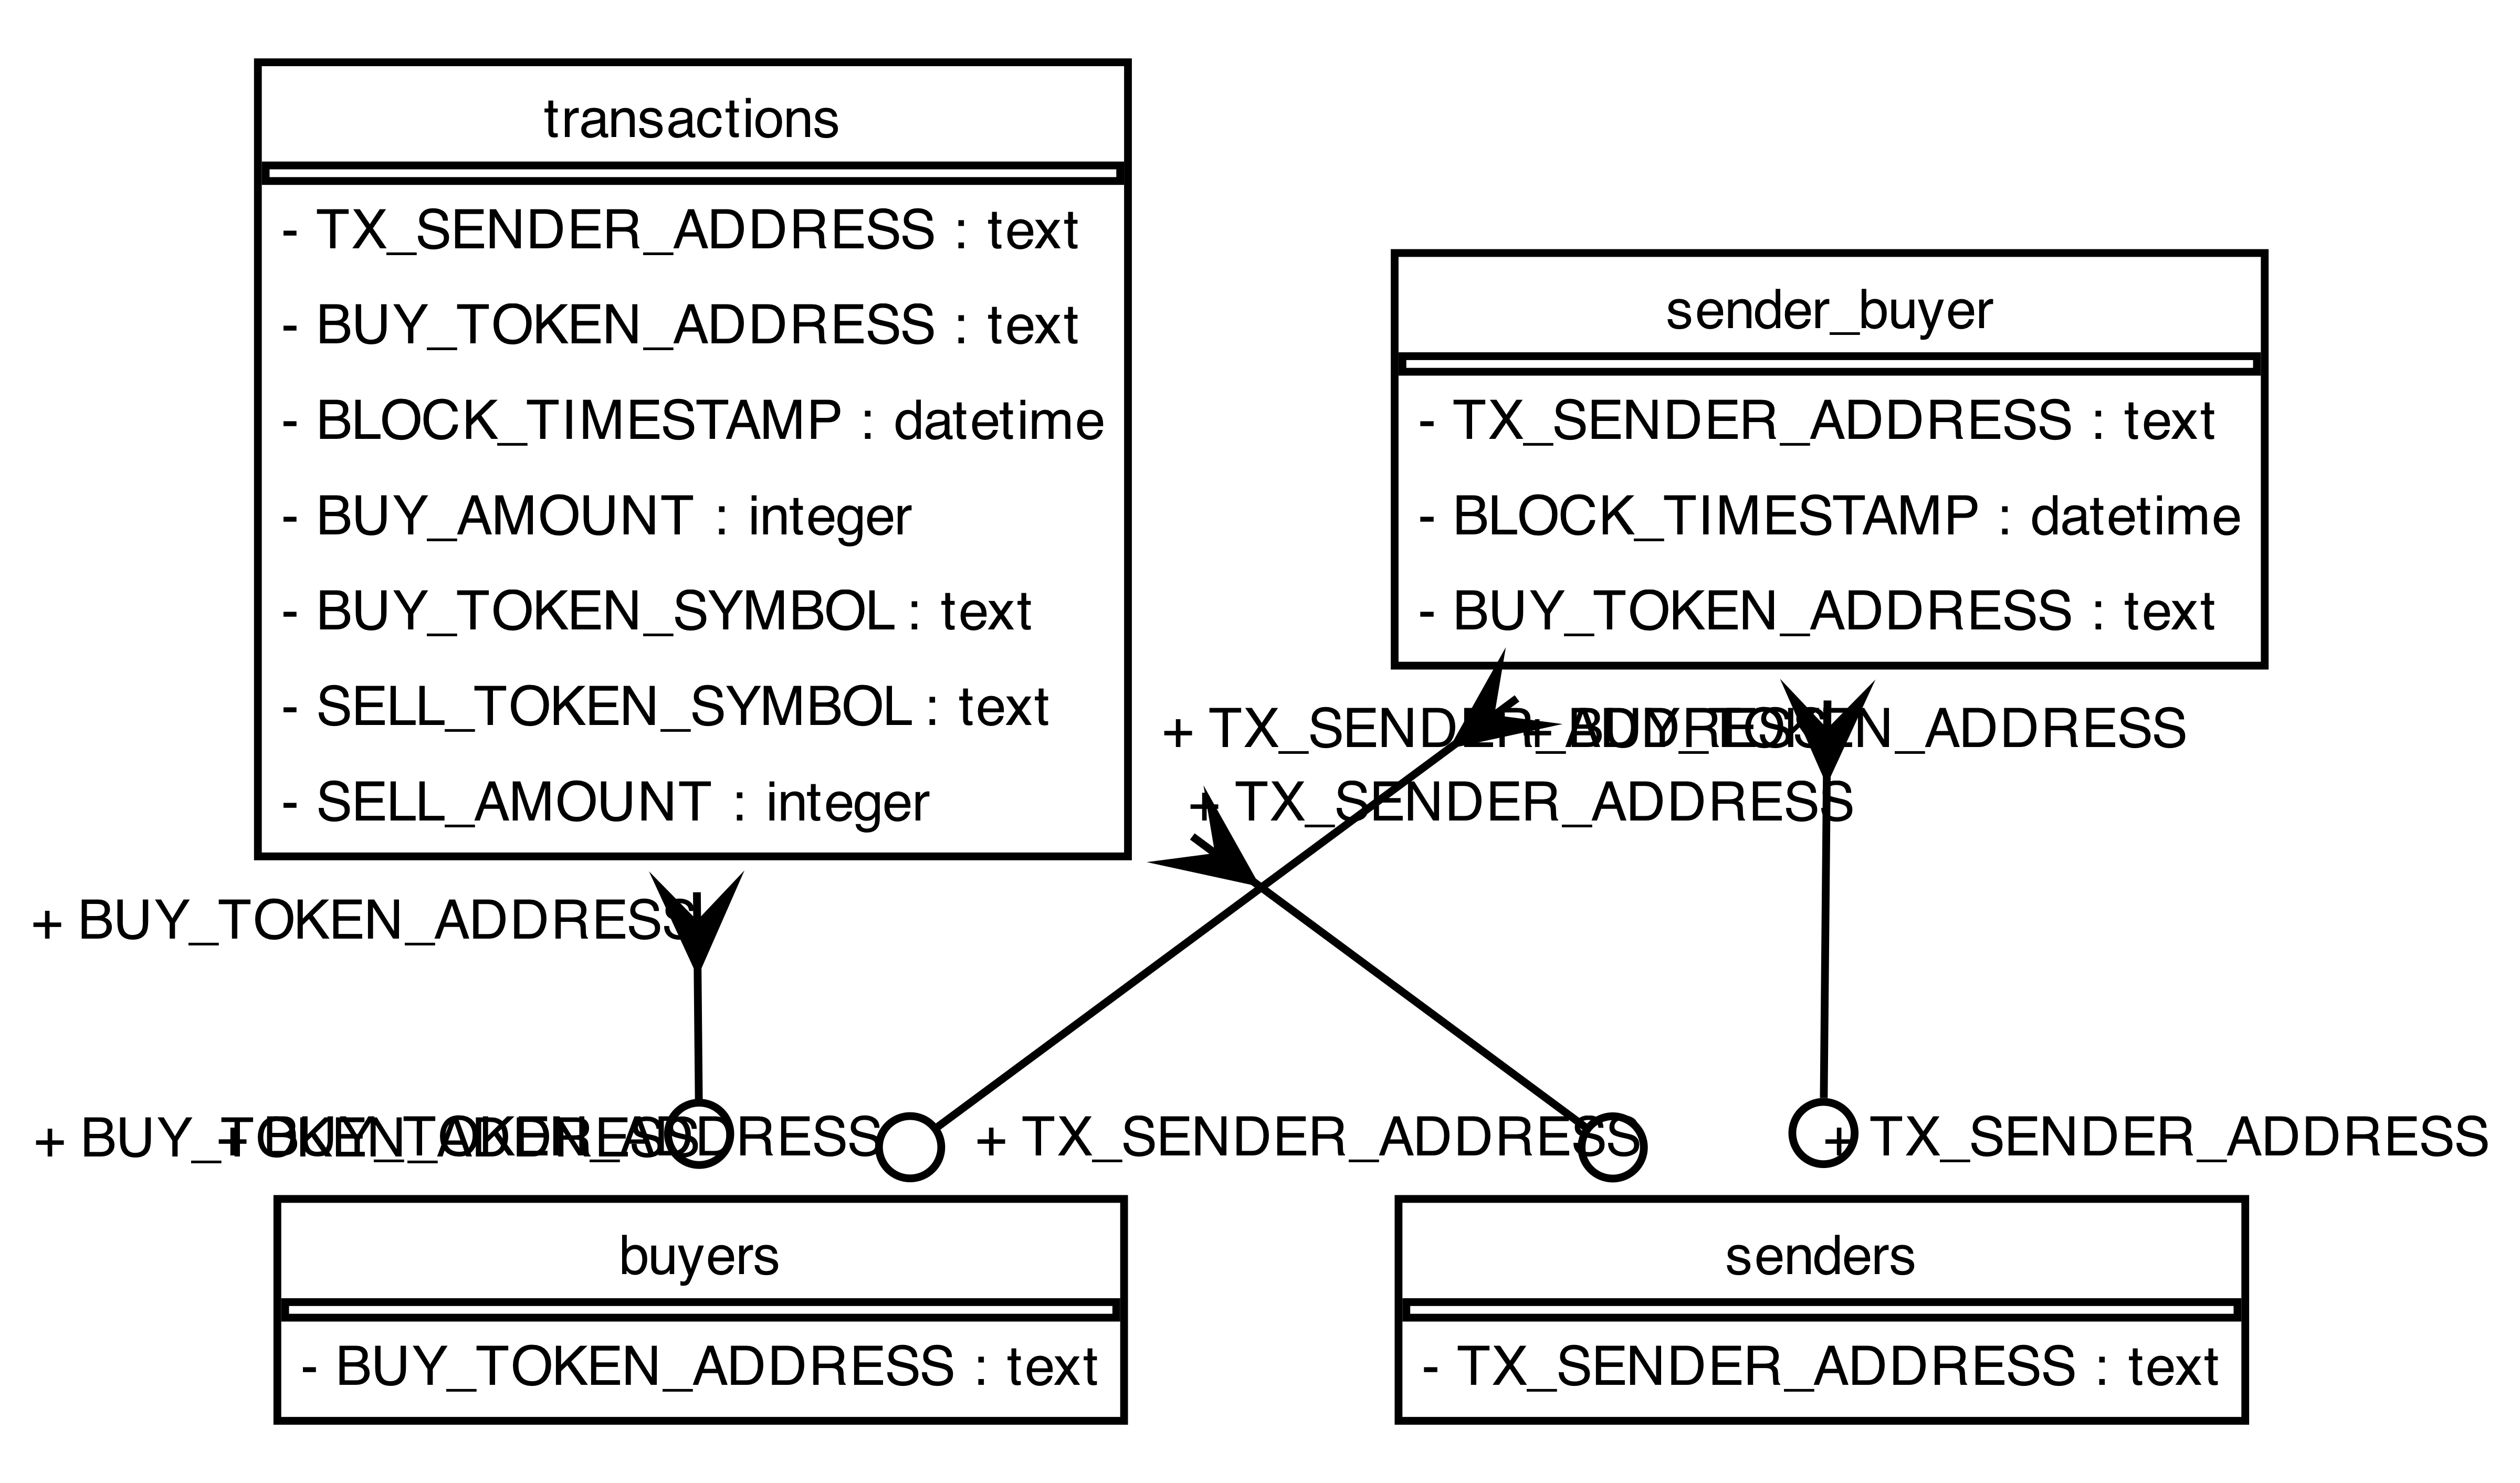

In [13]:
# we can also visualize the dataset 
# (Note: this requires Python 3.11)
from IPython.display import Image, display

graph = dataset.visualize_dataset(show_dtypes=True)
graph.set_graph_defaults(size="50,50!")  # Increase graph size
plt = Image(graph.create_png(), width=600, height=600)
display(plt)

## 🚀 GNN Model Training

Now that our dataset is ready, we can train our first GNN model. We’ll begin by defining a **configuration** that specifies the training parameters, such as model architecture, optimizer settings, and training duration.

Next, we’ll instantiate a **trainer** using this configuration. The trainer will consume the dataset we previously created and manage the entire training process. By calling the `fit()` method on the trainer, we initiate a training job—whose progress and status can be monitored throughout execution.



In [14]:
from rai_gnns_experimental import TrainerConfig
from rai_gnns_experimental import Trainer

# the first step will be to define a configuration for our Trainer.
# the configuration includes many parameters that are explained in
# detail in the documentation. It does not only provide parameters
# for the graph neural network but also parameters for other components
# of the model (such as feature extractors, prediction head parameters,
# training parameters etc.)
model_config = TrainerConfig(
    connector=connector,
    device="cuda",  # either 'cuda' or 'cpu'
    n_epochs=3,
    max_iters=200,
    text_embedder="model2vec-potion-base-4M",
)

In [15]:
# we initialize now our trainer object with the trainer configuration
# the trainer object can be used to train a model, to perform inference
# or to perform training & inference.
trainer = Trainer(connector=connector, config=model_config)

In [16]:
# in our first example we will use the trainer to perform training only.
# every time the trainer is "executed" (calling fit(), predict() or fit_predict())
# it returns a job object that can be used to monitor the current running job.
# See the documentation for the meaning of the job statuses
train_job = trainer.fit(dataset=dataset)

In [17]:
# now we can monitor the job status
# observe that once the job is running we also get back an experiment name
# we will see later how we can use that to perform inference
train_job.get_status()

{'job_id': '01bd3a00-0000-21ef-001d-cf8b0009ea52', 'status': 'RUNNING', 'started_at': '2025-06-23T18:08:06.060274', 'updated_at': '2025-06-23T18:08:06.060283', 'experiment_name': 'tokenflow/link_prediction/sender_buyer', 'job_type': 'train'}


{'job_id': '01bd3a00-0000-21ef-001d-cf8b0009ea52',
 'status': 'RUNNING',
 'started_at': '2025-06-23T18:08:06.060274',
 'updated_at': '2025-06-23T18:08:06.060283',
 'experiment_name': 'tokenflow/link_prediction/sender_buyer',
 'job_type': 'train'}

In [19]:
# we can also stream the logs of the training job in real time
# Hint: You can stop the cell execution to stop monitoring of logs
# Hint: At this point you can also open the MLFLow URL to monitor your experiments
train_job.stream_logs()


Monitoring logs for job ID: 01bd3a00-0000-21ef-001d-cf8b0009ea52
--------------------------------------------------------------------------------
2025-06-23 18:08:06,069 - INFO - Job 01bd3a00-0000-21ef-001d-cf8b0009ea52 started
2025-06-23 18:08:06,336 - INFO - Successfully loaded snwoflake table: GNN_TOKENFLOW.DATA.BUYERS

2025-06-23 18:08:07,096 - INFO - Logs sent to controller
2025-06-23 18:08:07,701 - INFO - Successfully loaded snwoflake table: GNN_TOKENFLOW.DATA.TRANSACTIONS

2025-06-23 18:08:08,308 - INFO - Successfully loaded snwoflake table: GNN_TOKENFLOW.DATA.SENDERS

2025-06-23 18:08:08,362 - INFO - Job status fetched: 01bd3a00-0000-2219-001d-cf8b0009ac56
2025-06-23 18:08:08,482 - INFO - Creating Database object ...

2025-06-23 18:08:08,482 - INFO - Database creation completed in 0.00 seconds.

2025-06-23 18:08:08,483 - INFO - Reindexing primary and foreign keys...

2025-06-23 18:08:08,483 - INFO - Reindexing primary keys for table 'buyers'

2025-06-23 18:08:08,484 - INFO - R

In [ ]:
# hint: one can cancel a running job as well
# train_job.cancel()

In [20]:
from rai_gnns_experimental import JobManager
# it might be the case that we have lost track of
# the jobs that we are running. To this end we also
# provide to the user a JobManager object that can
# give us the status of all current jobs. Let's see
# an example:
job_manager = JobManager(connector=connector)
job_manager.show_jobs()

{'active_job': [],
 'n_queued_jobs': 0,
 'queued_jobs': [],
 'completed_jobs': [['01bd3a00-0000-21ef-001d-cf8b0009ea52', 'train']],
 'failed_jobs': [['01bd39ed-0000-21f0-001d-cf8b00099cea', 'train'],
  ['01bd39f2-0000-220c-001d-cf8b000a01fe', 'train'],
  ['01bd39f8-0000-21ec-001d-cf8b0009bb5e', 'train']],
 'canceled_jobs': []}

In [21]:
# we can also get back job details using it's job id
foo_job = job_manager.fetch_job("01bd3a00-0000-21ef-001d-cf8b0009ea52")
# hint: the job manager can be used to cancel any job as well

{'job_id': '01bd3a00-0000-21ef-001d-cf8b0009ea52', 'status': 'COMPLETED', 'started_at': '2025-06-23T18:08:06.060274', 'finished_at': '2025-06-23T18:09:28.410191', 'updated_at': '2025-06-23T18:09:28.410195', 'experiment_name': 'tokenflow/link_prediction/sender_buyer', 'job_type': 'train', 'model_run_id': '6f68c77ca29e48d7b31d2046e2cc2a89', 'result': {'metrics': {'1': {'train_loss': 0.3042586995395246, 'val_metrics': {'link_prediction_precision': 0.058130081300813014, 'link_prediction_recall': 0.46602566229743936, 'link_prediction_map': 0.26430127473507264}, 'tune_metric': 'link_prediction_map', 'learning_rate': 0.0007500025000000001}, '2': {'train_loss': 0.16953456439244574, 'val_metrics': {'link_prediction_precision': 0.05720092915214866, 'link_prediction_recall': 0.4584530722858248, 'link_prediction_map': 0.3280744763044414}, 'tune_metric': 'link_prediction_map', 'learning_rate': 0.0002500075000000001}, '3': {'train_loss': 0.14525430436486453, 'val_metrics': {'link_prediction_precisio

## 🔍 Inference Using a Trained Model

Finally, we’ll demonstrate how to perform inference using the model we’ve just trained. In this example, we'll directly use the recently trained model to generate predictions.

For more advanced use cases—such as registering a model for reuse or automatically selecting the best-performing model—please refer to the [documentation](GNN_SDK_DOCUMENTATION.md) for further guidance.


In [ ]:
from rai_gnns_experimental import OutputConfig

output_config = OutputConfig.snowflake(database_name="GNN_TOKENFLOW", schema_name="PUBLIC")

inference_job = trainer.predict(
    output_alias="TEST_PREDS",
    output_config=output_config,
    test_batch_size=128,
    dataset=dataset,
    model_run_id=train_job.model_run_id,
    extract_embeddings=True,
)


In [24]:
inference_job.stream_logs()


Monitoring logs for job ID: 01bd3a02-0000-21ef-001d-cf8b0009eaee
--------------------------------------------------------------------------------
2025-06-23 18:10:38,095 - INFO - Job 01bd3a02-0000-21ef-001d-cf8b0009eaee started
2025-06-23 18:10:38,399 - INFO - Successfully loaded snwoflake table: GNN_TOKENFLOW.DATA.BUYERS

2025-06-23 18:10:39,147 - INFO - Successfully loaded snwoflake table: GNN_TOKENFLOW.DATA.TRANSACTIONS

2025-06-23 18:10:39,157 - INFO - Logs sent to controller
2025-06-23 18:10:39,551 - INFO - Successfully loaded snwoflake table: GNN_TOKENFLOW.DATA.SENDERS

2025-06-23 18:10:40,369 - INFO - Creating Database object ...

2025-06-23 18:10:40,369 - INFO - Database creation completed in 0.00 seconds.

2025-06-23 18:10:40,369 - INFO - Reindexing primary and foreign keys...

2025-06-23 18:10:40,369 - INFO - Reindexing primary keys for table 'buyers'

2025-06-23 18:10:40,371 - INFO - Reindexing primary keys for table 'senders'

2025-06-23 18:10:40,372 - INFO - Updating fore